In [1]:
import json
import operator
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import pandas as pd
import random
import pylab
import matplotlib.pyplot as plt
from difflib import get_close_matches
from collections import defaultdict

In [25]:
plotly.tools.set_credentials_file(username='KavyaP', api_key='MszYFcAggAFUAOdZ92Wx')

In [3]:
data = []
for line in open('business.json','r'): 
     data.append(json.loads(line))

### Categories vs Business

In [4]:
CategoryBasedBus = defaultdict(int)
for d in data:
    for c in d['categories']:
        CategoryBasedBus[c] +=1   

In [5]:
PopularCategory = set()
total_reviews_main = 0
threshold = 50
CategoryBasedBusSorted = {}

CategoryBasedBusSorted = dict(sorted(CategoryBasedBus.items(),key=operator.itemgetter(1),reverse=True))
review_count = 0
for category, review in CategoryBasedBusSorted.items():
    PopularCategory.add(category)
    review_count += review
    if review_count > total_reviews_main*1.0*threshold/(100.0):
        break

In [6]:
top_category_list = []
top_category_reviews = []
count = 0
total_rows_in_plot = 9
for c,r in CategoryBasedBusSorted.items():
    count+=1
    print (c,r)
    top_category_list.append(c)
    top_category_reviews.append(r)
    if count > total_rows_in_plot:
        break

Restaurants 54618
Shopping 27971
Food 24777
Beauty & Spas 17014
Home Services 16205
Health & Medical 14230
Nightlife 12154
Local Services 11232
Automotive 11052
Bars 10563


In [7]:
top_category_list,top_category_reviews, total_reviews_main

(['Restaurants',
  'Shopping',
  'Food',
  'Beauty & Spas',
  'Home Services',
  'Health & Medical',
  'Nightlife',
  'Local Services',
  'Automotive',
  'Bars'],
 [54618, 27971, 24777, 17014, 16205, 14230, 12154, 11232, 11052, 10563],
 0)

In [8]:
plot1 = []
bad_okay_good=[10000, 20000, 30000,50000]
for counter in range(total_rows_in_plot):
    plot1.append({"title":top_category_list[counter],"subtitle":"dummy","ranges":bad_okay_good,"measures":[top_category_reviews[counter],top_category_reviews[counter]+1],"markers":[top_category_reviews[counter]]})
plot1 = json.dumps(plot1)

In [9]:
plot1_data = pd.read_json(plot1)
fig1 = ff.create_bullet(plot1_data, markers="markers", measures='measures',ranges="ranges",subtitles="subtitle",titles="title")
plotly.offline.plot(fig1, filename = "restaurant.html")

'file:///Users/kavyaputluri/Documents/ECE 180/Project/restaurant.html'

### Geographic Distribution

In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [59]:
restaurant_data = []
for d in data:
    if 'Restaurants' in d['categories']:
        restaurant_data.append(d)

In [16]:
CityBasedBus = defaultdict(int)
PopularCity = set()
total_reviews = 0
threshold = 70
for business in restaurant_data:
    city = business['city']
    review_count = business['review_count']
    CityBasedBus[city] += review_count
    total_reviews += review_count
    
CityBasedBusSorted = dict(sorted(CityBasedBus.items(),key=operator.itemgetter(1), reverse=True))
review_count = 0
for city, review in CityBasedBusSorted.items():
    PopularCity.add(city)
    review_count += review
    if review_count > total_reviews*1.0*threshold/(100.0):
        break

In [104]:
PopularCityListExpanded = []
cityList = list(CityBasedBusSorted.keys())
for city in PopularCity:
    PopularCityListExpanded += get_close_matches(city, cityList,20)
    

In [102]:
popular_city_restaurant_data = [] #Will act as business.json
business_id_to_use = [] #Will be used to generate review.json
for business in restaurant_data:
    city = business['city']
    if city in PopularCityListExpanded:
        popular_city_restaurant_data.append(business)
        business_id_to_use.append(business['business_id'])

In [103]:
total_cities_plot = 200

In [93]:
count = 0
geo_fd = open("geogrpahy.csv","w")
geo_fd.write("name,review,lat,lon\n")
for city, review in CityBasedBusSorted.items():
    try:
        location = geolocator.geocode(city)
        geo_fd.write(city+","+str(review)+","+str(location.latitude)+","+str(location.longitude)+"\n")
    except:
        break
    count += 1
    if count == total_cities_plot:
        break
geo_fd.close()
total_cities_plot = count

In [94]:
count = 0
cities = []
scale = [400,300,200,100,50]
df = pd.read_csv('geogrpahy.csv',encoding = "ISO-8859-1")
df.head()
limits = [(0,4),(4,12),(12,24),(24,40),(40,total_cities_plot)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        marker = dict(
            size = df_sub['review']/scale[i],
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
    )
    cities.append(city)
    

layout = dict(
        title = 'City Based Review Popularity of Restaurants',
        showlegend = True,
        geo = dict(
            scope='usa',
            #projection=dict( type='natural earth' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig2 = dict(data=cities, layout = layout)
plotly.offline.plot(fig2, filename="geography.html")
    

'file:///Users/kavyaputluri/Documents/ECE 180/Project/geography.html'

### Price Distribution

In [12]:
restaurant_data = []
for d in data:
    if 'Restaurants' in d['categories']:
        restaurant_data.append(d)

In [13]:
count = defaultdict(int)

for d in restaurant_data:
    if 'RestaurantsPriceRange2' in d['attributes']:
        count[d['attributes']['RestaurantsPriceRange2']] +=1 
    else:
        prc = random.randint(1,4)
        count[prc] +=1

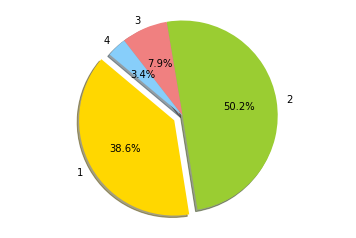

In [14]:
labels = '1', '2','3','4'
sizes = [count[1], count[2], count[3], count[4]]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
pylab.savefig('pricedistibution.png')
plt.show()

### Reviews vs Category

In [15]:
CategoryBasedReviews = defaultdict(int)
PopularCategory = set()
total_reviews_main = 0
threshold = 50
for business in data:
    categories = business['categories']
    review_count = business['review_count']
    total_reviews_main += review_count
    for category in categories:
        CategoryBasedReviews[category] += review_count
        
    
CategoryBasedReviewsSorted = dict(sorted(CategoryBasedReviews.items(),key=operator.itemgetter(1),reverse=True))
review_count = 0
for category, review in CategoryBasedReviewsSorted.items():
    PopularCategory.add(category)
    review_count += review
    if review_count > total_reviews_main*1.0*threshold/(100.0):
        break

In [16]:
top_category_list = []
top_category_reviews = []
count = 0
total_rows_in_plot = 7
for c,r in CategoryBasedReviewsSorted.items():
    count+=1
    print (c,r)
    top_category_list.append(c)
    top_category_reviews.append(r)
    if count > total_rows_in_plot:
        break

Restaurants 3221032
Food 991892
Nightlife 877146
Bars 806693
American (New) 520330
American (Traditional) 520318
Breakfast & Brunch 461388
Event Planning & Services 387017


In [17]:
plot1 = []
bad_okay_good=[500000,1000000,3000000]
for counter in range(total_rows_in_plot):
    plot1.append({"title":top_category_list[counter],"subtitle":"dummy","ranges":bad_okay_good,"measures":[top_category_reviews[counter],top_category_reviews[counter]+1],"markers":[top_category_reviews[counter]]})
plot1 = json.dumps(plot1)

In [18]:
plot1_data = pd.read_json(plot1)
fig1 = ff.create_bullet(plot1_data, markers="markers", measures='measures',ranges="ranges",subtitles="subtitle",titles="title")
plotly.offline.plot(fig1, filename = "restaurant.html")

'file:///Users/kavyaputluri/Documents/ECE 180/Project/restaurant.html'

### Table with attributes

In [19]:
restaurant_data = []
for d in data:
    if 'Restaurants' in d['categories']:
        restaurant_data.append(d)

In [30]:
### Business Accepts Credit Cards
count_Credit = defaultdict(int)
for d in restaurant_data:
    if 'BusinessAcceptsCreditCards' in d['attributes']:
        count_Credit[d['attributes']['BusinessAcceptsCreditCards']] += 1
    else:
        pred = random.choice([True, False])
        count_Credit[pred] +=1
        
### Good for Kids        
count_GfK = defaultdict(int)
for d in restaurant_data:
    if 'GoodForKids' in d['attributes']:
        count_GfK[d['attributes']['GoodForKids']] += 1
    else:
        pred = random.choice([True, False])
        count_GfK[pred] +=1

### Happy Hour
count_HH = defaultdict(int)
for d in restaurant_data:
    if 'HappyHour' in d['attributes']:
        count_HH[d['attributes']['HappyHour']] += 1
    else:
        pred = random.choice([True, False])
        count_HH[pred] +=1

### HasTV
count_TV = defaultdict(int)
for d in restaurant_data:
    if 'HasTV' in d['attributes']:
        count_TV[d['attributes']['HasTV']] += 1
    else:
        pred = random.choice([True, False])
        count_TV[pred] +=1

### Good for Groups
count_GG = defaultdict(int)
for d in restaurant_data:
    if 'GoodForGroups' in d['attributes']:
        count_GG[d['attributes']['GoodForGroups']] += 1
    else:
        pred = random.choice([True, False])
        count_GG[pred] +=1

### Parking
count_Pkng = defaultdict(int)
for d in restaurant_data:
    if 'BusinessParking' in d['attributes']:
        count_Pkng[(d['attributes']['BusinessParking']['garage'] or d['attributes']['BusinessParking']['lot'] or d['attributes']['BusinessParking']['street'])] += 1
    else:
        pred = random.choice([True, False])
        count_Pkng[pred] +=1





In [31]:
print( count_Credit)
print( count_GfK)
print (count_HH)
print (count_TV)
print( count_GG)
print (count_Pkng)

defaultdict(<class 'int'>, {True: 48201, False: 6417})
defaultdict(<class 'int'>, {True: 43005, False: 11613})
defaultdict(<class 'int'>, {True: 28913, False: 25705})
defaultdict(<class 'int'>, {True: 27378, False: 27240})
defaultdict(<class 'int'>, {False: 27125, True: 27493})
defaultdict(<class 'int'>, {True: 31782, False: 22836})


In [47]:
### Percentage
def percent(a,b):
    p = (a/(a+b))*100
    return round(p,2)

percentTrue = []
percentTrue.append(percent(count_Credit[True], count_Credit[False]))
percentTrue.append(percent(count_GfK[True], count_GfK[False]))
percentTrue.append(percent(count_HH[True], count_HH[False]))
percentTrue.append(percent(count_TV[True], count_TV[False]))
percentTrue.append(percent(count_GG[True], count_GG[False]))
percentTrue.append(percent(count_Pkng[True], count_Pkng[False]))

percentFalse = []
for d in percentTrue:
    percentFalse.append(round(100-d,2))


In [46]:
trace = go.Table(
    header=dict(values=['Attribute', 'True', 'False', '% of True','% of False'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['center'] 
               )
    ,
    cells=dict(values=[['Business Accepts Credit Cards', 'Good For Kids', 'Happy Hour', 'Has TV','Good For Groups','Business Parking'],
                       [count_Credit[True], count_GfK[True], count_HH[True],count_TV[True],count_GG[True],count_Pkng[True]],
                       [count_Credit[False], count_GfK[False], count_HH[False],count_TV[False],count_GG[False],count_Pkng[False]],
                       [88.25, 78.74, 52.94, 50.13, 50.34, 58.19],
                       [11.75, 21.26, 47.06, 49.87, 49.66, 41.81],
                       ]))

layout = dict(width=600, height=300)
datum = [trace]
fig = dict(data=datum, layout=layout)
py.iplot(datum, filename = 'styled_table')